In [55]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import tensorflow as tf
from tensorflow import keras

In [56]:
import os
results = np.load('/Users/sean/Desktop/college/intern/2D Wall/2D_Wall_Propped.npy')

In [57]:
E = 3e10 #Pa
nu = 0.2 # Poisson's ratio
G = E / (2 * (1 + nu)) # Shear modulus
rho = 2400 # kg/m^3

mesh_size = 0.05

width = 5   # m
depth = 8   # m
t = 0.1     # m
D =  E * t**3 / (12 * (1 - nu**2))

x_prop = width / 2

H_exposed = 5.0
D_embed = 3.0
H_total = H_exposed + D_embed
L = H_total
EI = 20e6  # Nm²
gamma = 18.0 * 1e3  # N/m³
Ka = 0.333
Kp_mobilised = 1.5  # Reduced passive pressure coefficient
Kp = 3.0
z_prop = 2.5       # Depth of prop from top [m]
zR_prop = 60e3   # N/m (resisting direction, into wall)
zR_prop *= width

tol = 1e-7

z_dense_lim1, z_dense_lim2 = 1.5, 3.5
x_dense_lim1, x_dense_lim2 = 1.5, 3.5       # Dense region limits for z and x

def is_in_dense_region(z, x):
    return (z_dense_lim1 <= z) & (z <= z_dense_lim2) & (x_dense_lim1 <= x) & (x <= x_dense_lim2)

Text(0.5, 0.92, 'delta z')

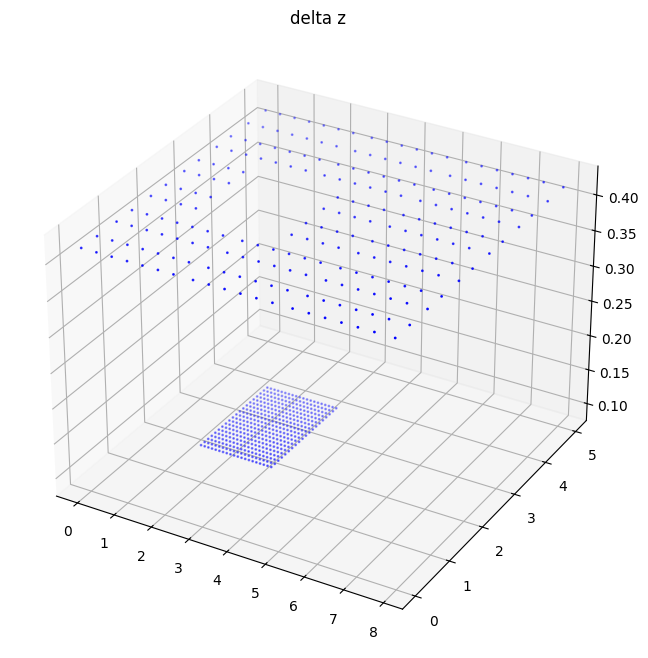

In [58]:
Noise = True

x_raw, z_raw, y_raw = np.split(results, 3, axis = -1)
y_raw = -y_raw  #positive deflection is downwards
x_raw_flatten, z_raw_flatten, y_raw_flatten = x_raw.flatten(), z_raw.flatten(), y_raw.flatten()
x_raw_squeeze = np.squeeze(x_raw)
z_raw_squeeze = np.squeeze(z_raw)
y_raw_squeeze = np.squeeze(y_raw)

zdim_raw = z_raw.shape[0]
xdim_raw = z_raw.shape[1]
zdim = 20
xdim = int(zdim / depth * width)

z_sample_index = np.linspace(0, zdim_raw-1, zdim, dtype=int)
x_sample_index = np.linspace(0, xdim_raw-1, xdim, dtype=int)

z_sampled_raw = np.zeros_like(z_raw)
x_sampled_raw = np.zeros_like(x_raw)
y_sampled_raw = np.zeros_like(y_raw)

delta_z , delta_x = [], []  #local spacing for z and x

for z_in in range(zdim_raw):
    for x_in in range(xdim_raw):
        z, x, y = z_raw[z_in, x_in], x_raw[z_in, x_in], y_raw[z_in, x_in]
        if is_in_dense_region(z, x):
            z_sampled_raw[z_in, x_in] = z
            x_sampled_raw[z_in, x_in] = x
            y_sampled_raw[z_in, x_in] = y
            delta_z.append(depth / zdim_raw)
            delta_x.append(width / xdim_raw)    #denser spacing

        else:
            if (not is_in_dense_region(z,x) and (z_in in z_sample_index) and (x_in in x_sample_index)):
                z_sampled_raw[z_in, x_in] = z
                x_sampled_raw[z_in, x_in] = x
                y_sampled_raw[z_in, x_in] = y
                delta_z.append(depth / zdim)
                delta_x.append(width / xdim)
                
            else:
                z_sampled_raw[z_in, x_in] = np.nan
                x_sampled_raw[z_in, x_in] = np.nan
                y_sampled_raw[z_in, x_in] = np.nan  #otherwise dont sample
                

z_sampled_flatten = z_sampled_raw.flatten()
x_sampled_flatten = x_sampled_raw.flatten()
y_sampled_flatten = y_sampled_raw.flatten()

z_flatten = z_sampled_flatten[~np.isnan(z_sampled_flatten)]
x_flatten = x_sampled_flatten[~np.isnan(x_sampled_flatten)]
y_flatten = y_sampled_flatten[~np.isnan(y_sampled_flatten)]

z_norm_at_z_boundaries = np.concatenate((np.zeros(xdim), np.ones(xdim)))
x_norm_at_z_boundaries = np.concatenate((np.linspace(0, 1, xdim), np.linspace(0, 1, xdim)))
zxstack_at_z_boundaries = np.stack((z_norm_at_z_boundaries, x_norm_at_z_boundaries), axis=-1)
zxstack_at_z_boundaries_tf = tf.convert_to_tensor(zxstack_at_z_boundaries, dtype=tf.float32)

z_norm_at_x_boundaries = np.concatenate((np.linspace(0, 1, zdim), np.linspace(0, 1, zdim)))
x_norm_at_x_boundaries = np.concatenate((np.zeros(zdim), np.ones(zdim)))
zxstack_at_x_boundaries = np.stack((z_norm_at_x_boundaries, x_norm_at_x_boundaries), axis=-1)
zxstack_at_x_boundaries_tf = tf.convert_to_tensor(zxstack_at_x_boundaries, dtype=tf.float32)

if Noise:
    std = 0.01 * np.max(y_flatten)
    noise = np.random.normal(0, std, size=y_flatten.shape)
    y_flatten += noise

z_max = np.max(z_raw_flatten)
x_max = np.max(x_raw_flatten)
y_max = np.max(abs(y_raw_flatten))

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(z_flatten, x_flatten, delta_x, c='b', marker='o', s=1)
ax.set_title('delta z')

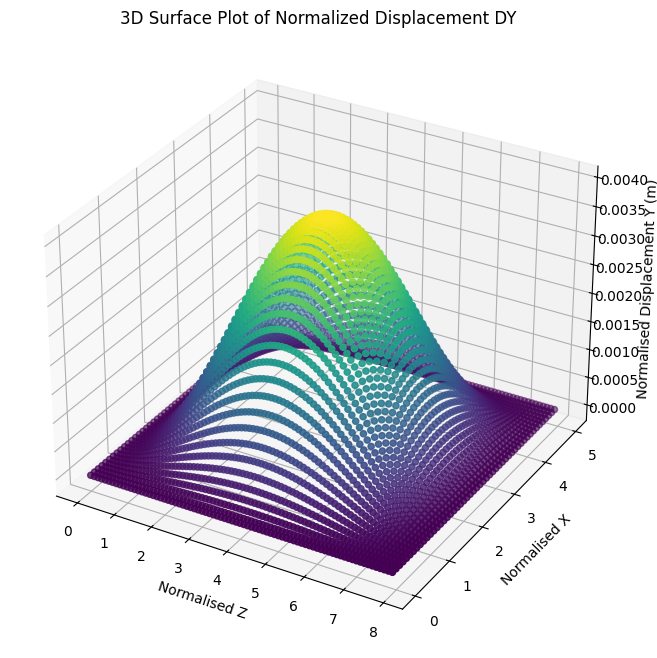

In [59]:
z_norm_flatten = z_flatten / z_max
x_norm_flatten = x_flatten / x_max
y_norm_flatten = y_flatten / y_max

z_norm_flatten_tf = tf.convert_to_tensor(z_norm_flatten, dtype=tf.float32)
x_norm_flatten_tf = tf.convert_to_tensor(x_norm_flatten, dtype=tf.float32)
y_norm_flatten_tf = tf.convert_to_tensor(y_norm_flatten, dtype=tf.float32)

delta_z = np.array(delta_z)
delta_x = np.array(delta_x)

results_norm_flatten = np.stack((z_norm_flatten, x_norm_flatten, y_norm_flatten, delta_z, delta_x), axis = -1)
results_norm_flatten_tf = tf.convert_to_tensor(results_norm_flatten, dtype=tf.float32)

phi = (x_raw_flatten / x_max *(1-x_raw_flatten / x_max))**2 * (z_raw_flatten / z_max*(1-z_raw_flatten / z_max))**2

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(z_raw_flatten, x_raw_flatten, phi, c = phi, cmap='viridis')
ax.set_xlabel('Normalised Z')
ax.set_ylabel('Normalised X')
ax.set_zlabel('Normalised Displacement Y (m)')
ax.set_title('3D Surface Plot of Normalized Displacement DY')

plt.show()

In [60]:
def q_soil_smooth(z, width=0.2):

    m1      =  Ka * gamma                                   # slope for z ≤ H
    m2      = (Ka - Kp_mobilised) * gamma                   # slope for z ≥ H
    c2      =  Kp_mobilised * gamma * H_exposed             # intercept so the
                                                            # two branches meet
    # Smooth switch 0→1 built from tanh
    w = 0.5 * (1 + np.tanh((z - H_exposed) / width))        # 0 left, 1 right

    return (1 - w) * (m1 * z) + w * (m2 * z + c2)

def gaussian_prop(z, x, force, xc = width/2, zc = z_prop, sigma = 1e-2):

    phi = force * tf.exp(-((x - xc)**2 + (z - zc)**2) / (2 * sigma**2))
    scale = 1 / (sigma * np.sqrt(2 * np.pi))
    
    return scale * phi

q_s = q_soil_smooth(z_flatten)
q_max = max(q_s)
q_norm = q_s / q_max
print(q_max)

30096.74183769898


Model: "functional_61"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_62      │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_57         │ (None, 1)         │          0 │ input_layer_62[0… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ subtract_29         │ (None, 1)         │          0 │ get_item_57[0][0] │
│ (Subtract)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_58         │ (None, 1)         │          0 │ get_item_57[0][0… │
│ (Multiply)          │                   │            │ subtract_29[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ power_29 (Power)    │ (None, 1)         │          0 │ multiply_58[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_31       │ (None, 1)         │     41,729 │ input_layer_62[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_59         │ (None, 1)         │          0 │ power_29[0][0],   │
│ (Multiply)          │                   │            │ sequential_31[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 41,729 (163.00 KB)

 Trainable params: 41,729 (163.00 KB)

 Non-trainable params: 0 (0.00 B)

(620, 1)


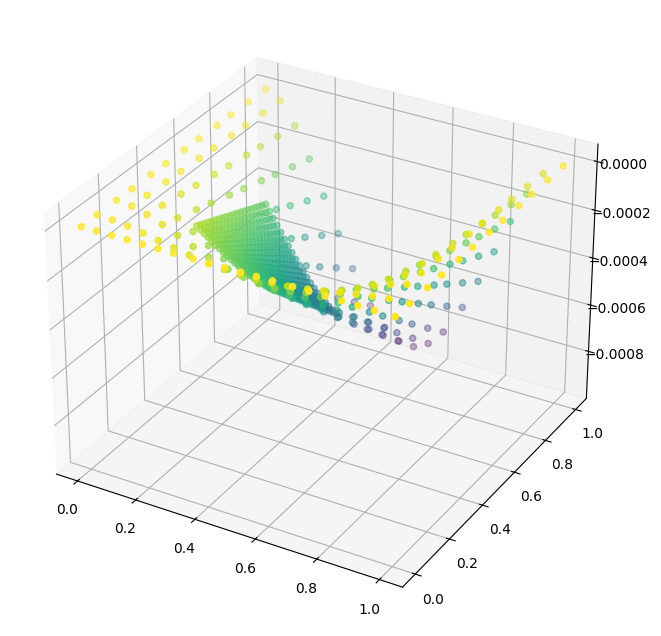

In [61]:
zxstack_tf = tf.convert_to_tensor(np.stack((z_norm_flatten, x_norm_flatten), axis=-1), dtype=tf.float32)
softmodel = keras.Sequential([
    keras.layers.Input(shape = (2,)),
    keras.layers.Dense(128, activation='swish'),
    keras.layers.Dense(128, activation='swish'),
    keras.layers.Dense(128, activation='swish'),
    keras.layers.Dense(64, activation='swish'),
    keras.layers.Dense(1)
])
inp = keras.Input(shape=(2,))

z_input = inp[...,0:1]
phi_z = (z_input * (1 - z_input)) ** 2

softoutput = softmodel(inp)
enforced_output = phi_z * softoutput
model = keras.Model(inputs=inp, outputs=enforced_output)
model.summary()

test = model(zxstack_tf)
print(test.shape)
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(z_norm_flatten, x_norm_flatten,test, c=test.numpy(), cmap='viridis')


In [62]:
# --- 8. Initialize b1, c1, b2, c2
m_a = tf.Variable(0.5, dtype=tf.float32)
m_p = tf.Variable(1, dtype=tf.float32)
m_prop = tf.Variable(1, dtype=tf.float32)


# --- 9. Learning Rate Scheduler ---
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0005, # Slightly lower initial LR
    decay_steps=10000,
    decay_rate=0.9
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)


physics loss

In [79]:

def laplacian(inputs, func = model):
    with tf.GradientTape(persistent=True) as tape2:
        tape2.watch(inputs)
        with tf.GradientTape() as tape1:
            tape1.watch(inputs)
            f = func(inputs)
        grad = tape1.gradient(f, inputs)  # shape (N, D)
        dz, dx = tf.unstack(grad, axis = -1)
    
    
    dz2 = tf.unstack(tape2.gradient(dz, inputs), axis = -1)[0]
    dx2 = tf.unstack(tape2.gradient(dx, inputs), axis = -1)[1]
    
    return dz2 / z_max**2 + dx2 / x_max**2  #since normalized input, scaling needed for laplacian

def first_order_grad(inputs):
    with tf.GradientTape() as tape:
        tape.watch(inputs)
        f = model(inputs)
    dz, dx = tf.unstack(tape.gradient(f, inputs), axis = -1)
    dz = dz / z_max
    dx = dx / x_max
    
    return f, dz, dx

Text(0.5, 0.92, 'initial loading prediction')

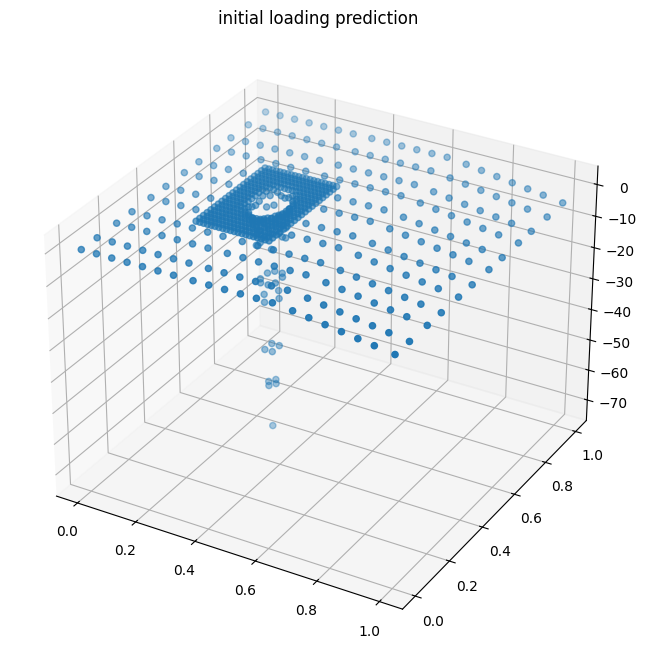

In [64]:
def gaussian_2D(z, x, force, deltaz_batch, deltax_batch, xc = x_prop, zc = z_prop, sigma = 0.15):

  dtype = z.dtype
  force, xc, zc, sigma = tf.cast(force, dtype), tf.cast(xc, dtype), tf.cast(zc, dtype), tf.cast(sigma, dtype)

  r2 = ((x - xc)**2 + (z - zc)**2) / (2 * sigma**2)
  phi = tf.exp(-r2)
  scale = force / (tf.reduce_sum(phi) * deltax_batch * deltaz_batch)

  return scale * phi

def piecewise_q(z_norm_flatten_tf, x_norm_flatten_tf, deltaz_batch, deltax_batch):  #input normalized
  
    z_phys = z_norm_flatten_tf * z_max
    x_phys = x_norm_flatten_tf * x_max
    
    q_s = tf.where(z_phys <= H_exposed, (m_a * gamma * Ka * z_phys), (m_a * gamma * Ka * z_phys - m_p*gamma*Kp*(z_phys-H_exposed)))
    q_prop = gaussian_2D(z_phys, x_phys, zR_prop, deltaz_batch, deltax_batch)
    
    return q_s - q_prop
  
delta_z_tf = tf.convert_to_tensor(delta_z, dtype=tf.float32)
delta_x_tf = tf.convert_to_tensor(delta_x, dtype=tf.float32)  

q_test = piecewise_q(z_norm_flatten_tf, x_norm_flatten_tf, delta_z_tf, delta_x_tf) / q_max
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(z_norm_flatten, x_norm_flatten, q_test)
ax.set_title('initial loading prediction')


In [65]:
N_DATA_ONLY_EPOCHS = 4000
N_BC_EPOCHS = 3000
N_PHYSICS_EPOCHS = 3000

@tf.function

def train_step(batch, epoch_val):
  z, x , y_true , deltaz_batch, deltax_batch= batch[:,0], batch[:,1], batch[:,2], batch[:,3], batch[:,4]
  
  physics_weight = tf.where(deltaz_batch == depth / zdim, 1.0, 0.001)  # Lighter physics weight on data in dense regions
  data_weight = tf.where(deltaz_batch == depth / zdim, 0.5, 5)  # Heavier data weight on data in dense regions
  
  with tf.GradientTape() as tape:
    zxstack = tf.stack((z, x), axis = -1)
    y_pred = model(zxstack)
    y_pred = tf.squeeze(y_pred, -1)  # Ensure y_pred is 1D
    data_loss = tf.reduce_mean(tf.square(data_weight * (y_true - y_pred)))
    
    #y_at_z_boundaries, gradz_at_z_boundaries, *_ = first_order_grad(zxstack_at_z_boundaries_tf)
    #bc_disp = tf.reduce_mean(tf.square(y_at_z_boundaries))
    #bc_z_loss = tf.reduce_mean(tf.square(gradz_at_z_boundaries))
    
    gradx_at_x_boundaries = first_order_grad(zxstack_at_x_boundaries_tf)[2]
    bc_x_loss = tf.reduce_sum(tf.square(gradx_at_x_boundaries)) 
    
    bc_loss = bc_x_loss #+ bc_disp + bc_z_loss +
      
    biharmonic = laplacian(zxstack, laplacian)
    q_pred = piecewise_q(z, x, deltaz_batch, deltax_batch)
    physics_residual = tf.square(physics_weight * (biharmonic * D * y_max / q_max - q_pred / q_max))
    physics_loss = tf.reduce_mean(physics_residual)

    if epoch_val < N_DATA_ONLY_EPOCHS:
        w_data, w_phys, w_bc = 1.0, 0.0, 0.0
    elif epoch_val < N_BC_EPOCHS:
        w_data, w_phys, w_bc = 1.0, 0.2, 0.1
    else:
        w_data, w_phys, w_bc = 1.0, 0.1, 0.2
        
    loss = w_data * data_loss + w_bc * bc_loss + w_phys * physics_loss

  variables = model.trainable_variables + [m_a, m_p]
  gradients = tape.gradient(loss, variables)
  optimizer.apply_gradients(zip(gradients, variables))
  del tape
  return loss, data_loss, bc_loss, physics_loss


In [66]:
def snapshot(model):
    snap = keras.models.clone_model(model)
    snap.build(model.input_shape)
    snap.set_weights(model.get_weights())
    return snap

training using shuffled batches

In [67]:
BATCH_SIZE  = 1024
SHUFFLE_BUF = 10_000

model_phase1, model_phase2 = model, model

dataset = (tf.data.Dataset.from_tensor_slices(
              results_norm_flatten_tf)
           .shuffle(SHUFFLE_BUF, reshuffle_each_iteration=True)
           .batch(BATCH_SIZE)
           .prefetch(tf.data.AUTOTUNE))

history        = {k: [] for k in ["loss", "data", "phys", "bc"]}
history_params = {"m_a": [], "m_p": []}

In [68]:
for epoch in range(N_DATA_ONLY_EPOCHS + N_BC_EPOCHS + N_PHYSICS_EPOCHS):
    for batch in dataset:
        loss, data_l, bc_l, phys_l = train_step(batch, tf.cast(epoch, tf.int32))

    history["loss"].append(float(loss.numpy()))
    history["data"].append(float(data_l.numpy()))
    history["phys"].append(float(phys_l.numpy()))
    history["bc"].append(float(bc_l.numpy()))
    history_params["m_a"].append(m_a.numpy())
    history_params["m_p"].append(m_p.numpy())

    if epoch % 50 == 0:
        print(f"Epoch {epoch:3d} | "
              f"loss {loss.numpy():.3e} | "
              f"data {data_l.numpy():.3e} | "
              f"bc {bc_l.numpy():.3e} | "
              f"phys {phys_l.numpy():.3e}")
    
    if epoch == N_DATA_ONLY_EPOCHS - 1:
        model_phase1 = snapshot(model)
    if epoch == N_DATA_ONLY_EPOCHS + N_BC_EPOCHS - 1:
        model_phase2 = snapshot(model)


2025-08-12 11:20:56.415690: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-08-12 11:20:56.557689: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch   0 | loss nan | data 2.116e+00 | bc 5.472e-07 | phys nan


2025-08-12 11:20:56.783861: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-08-12 11:20:57.257724: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-08-12 11:20:57.943553: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-08-12 11:20:59.100742: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch  50 | loss nan | data nan | bc nan | phys nan


2025-08-12 11:21:01.581254: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


KeyboardInterrupt: 

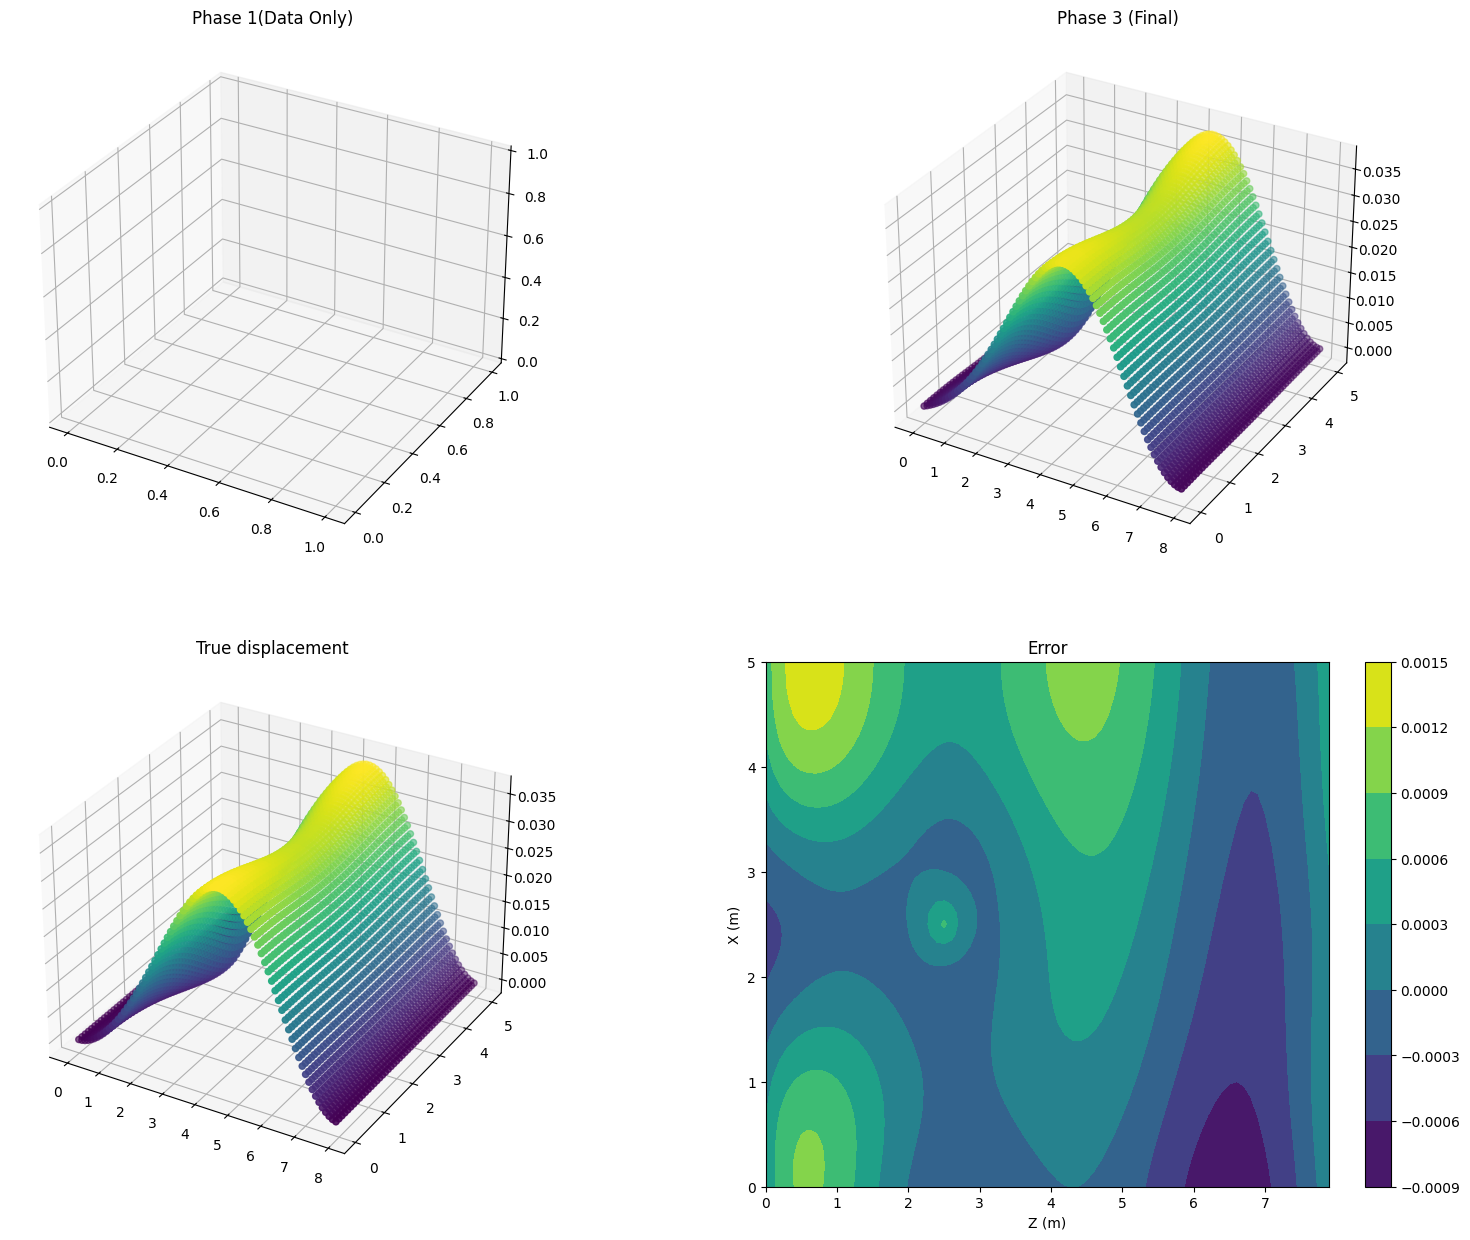

[0.00746748 0.00783792 0.00820139 0.00854155 0.00884911 0.00911525
 0.00933262 0.00949642 0.00960633 0.0096611  0.00966283 0.00961628
 0.00952705 0.00940486 0.00925359 0.00908991 0.00892242 0.00876149
 0.00861725 0.00850185 0.00842473 0.00839188 0.0084109  0.00848481
 0.0086148  0.00880113 0.00904235 0.00933233 0.00966414 0.01003137
 0.01042807 0.01084193 0.01126581 0.01169091 0.01210799 0.01251453
 0.01289916 0.01325863 0.01359054 0.01389116 0.01416158 0.01440219
 0.01461179 0.01479797 0.01496347 0.01511302 0.01525359 0.01539291
 0.01553912 0.01570046 0.01588852]


In [ ]:

zxstack = tf.stack((z_norm_flatten_tf, x_norm_flatten_tf), axis = -1)

y_pred_norm1 = model_phase1(zxstack)
y_pred_norm1 = np.squeeze(y_pred_norm1, -1)
y_pred1 = y_pred_norm1 * y_max

y_pred_norm2 = model_phase2(zxstack)
y_pred_norm2 = np.squeeze(y_pred_norm2, -1)
y_pred2 = y_pred_norm2 * y_max

y_pred_norm3 = model(zxstack)
y_pred_norm3 = np.squeeze(y_pred_norm3, -1)
y_pred3 = y_pred_norm3 * y_max

y_full_prediction = model(tf.stack([z_raw_flatten / z_max, x_raw_flatten / x_max], axis=-1))
y_full_prediction = y_full_prediction.numpy().reshape(z_raw_squeeze.shape) * y_max

fig = plt.figure(figsize=(20, 15))

ax1 = fig.add_subplot(221, projection = '3d')
ax1.scatter(x_flatten, z_flatten, y_pred1, c = y_pred1, cmap = 'viridis')
ax1.set_title('Phase 1(Data Only)')

ax2 = fig.add_subplot(222, projection='3d')
ax2.scatter(z_raw_squeeze, x_raw_squeeze, y_full_prediction, c = y_full_prediction, cmap = 'viridis')
ax2.set_title('Phase 3 (Final)')

ax3 = fig.add_subplot(223, projection = '3d')
ax3.scatter(z_raw_flatten, x_raw_flatten, y_raw_flatten, c = y_raw_flatten, cmap = 'viridis')
ax3.set_title('True displacement')



ax4 = fig.add_subplot(224)
ax4.contourf(z_raw_squeeze, x_raw_squeeze, y_full_prediction - y_raw_squeeze, cmap = 'viridis',)
plt.colorbar(ax4.contourf(z_raw_squeeze, x_raw_squeeze, y_full_prediction - y_raw_squeeze, cmap = 'viridis',))
ax4.set_xlabel('Z (m)')
ax4.set_ylabel('X (m)')
ax4.set_title('Error')

plt.show()

-nan nan


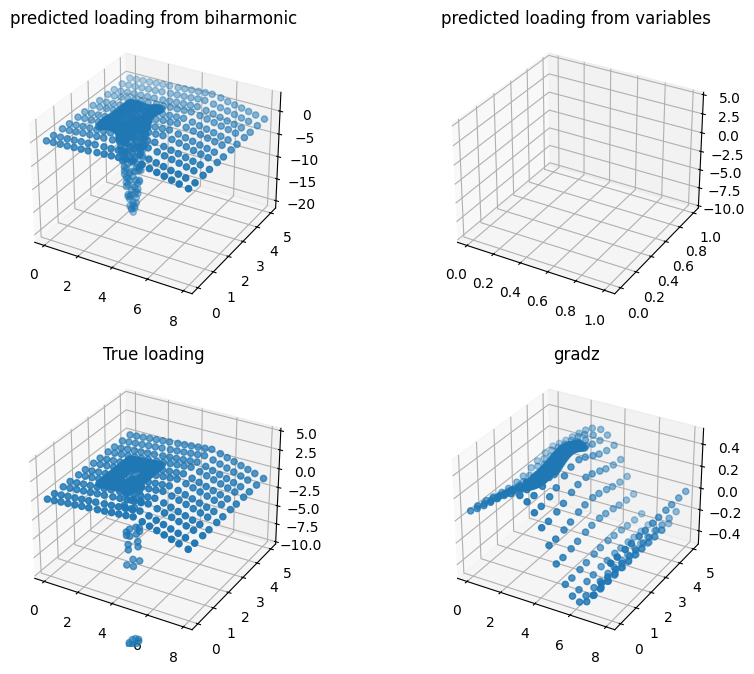

In [80]:

bih = laplacian(zxstack, laplacian)

cut = 0
fig = plt.figure(figsize=(10, 8))

ax1 = fig.add_subplot(221, projection = '3d')
ax1.scatter(z_flatten[cut*xdim:], x_flatten[cut*xdim:], bih[cut*xdim:]* D * y_max / q_max)
ax1.set_title('predicted loading from biharmonic')

q_params = piecewise_q(z_norm_flatten_tf, x_norm_flatten_tf, delta_z_tf, delta_x_tf)
ax2 = fig.add_subplot(222, projection = '3d')
ax2.scatter(z_flatten[cut*xdim:], x_flatten[cut*xdim:], q_params[cut*xdim:]/q_max)
ax2.set_zlim(-10, 5)
ax2.set_title('predicted loading from variables')

q_true = q_soil_smooth(z_flatten) - gaussian_2D(z_flatten, x_flatten, zR_prop, delta_z, delta_x)
ax3 = fig.add_subplot(223, projection = '3d')
ax3.scatter(z_flatten[cut*xdim:], x_flatten[cut*xdim:], q_true[cut*xdim:]/q_max)
ax3.set_zlim(-10, 5)
ax3.set_title('True loading')

*_, gz, gx = first_order_grad(zxstack)
ax4 = fig.add_subplot(224, projection = '3d')
ax4.scatter(z_flatten[cut*xdim:], x_flatten[cut*xdim:], gz[cut*xdim:])
ax4.set_title('gradz')
tf.print(m_a, m_p)

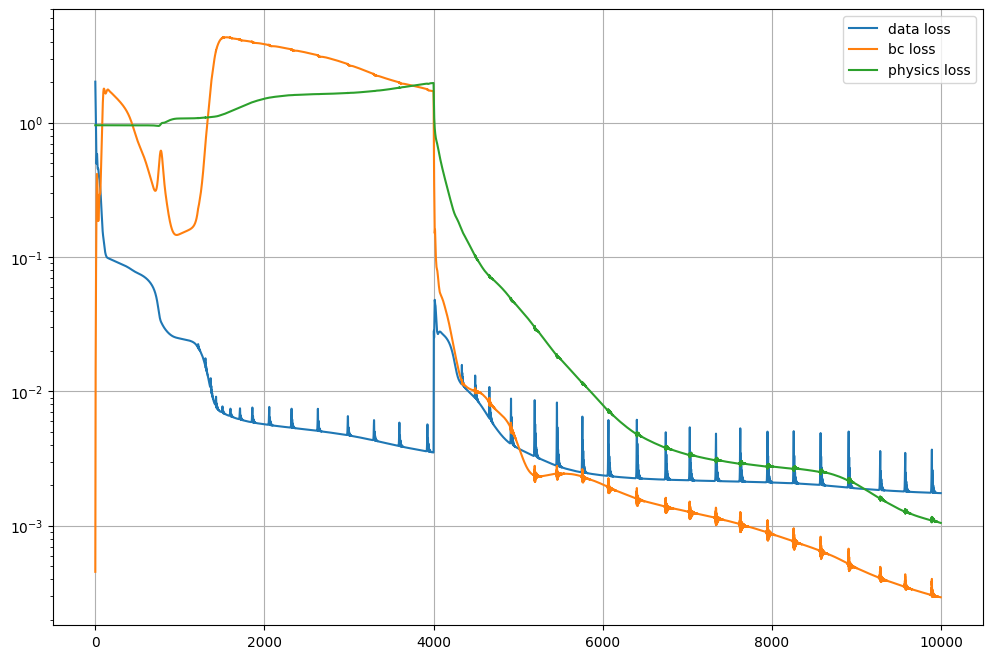

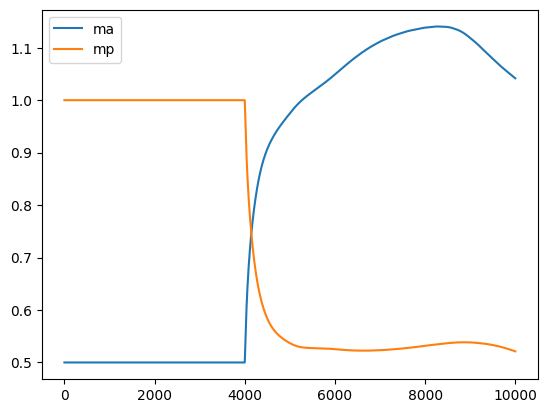

In [ ]:
epoch_plot = np.arange(len(history_params["m_a"]))

n = epoch

plt.figure(figsize=(12, 8))
plt.plot(epoch_plot[:n], history["data"][:n], label='data loss')
plt.plot(epoch_plot[:n], history["bc"][:n], label='bc loss')
plt.plot(epoch_plot[:n], history["phys"][:n], label='physics loss')
plt.yscale('log')
plt.legend()
plt.grid(True)
plt.show()

plt.plot(epoch_plot, history_params["m_a"], label='ma')
plt.plot(epoch_plot, history_params["m_p"], label='mp')
plt.legend()

In [ ]:
physics_weight = tf.where(delta_z == depth / zdim, 1.0, 0.001) 
biharmonic = laplacian(zxstack, laplacian)
q_pred = piecewise_q(z_norm_flatten_tf, x_norm_flatten_tf, delta_z, delta_x)
physics_residual = tf.square(physics_weight * (biharmonic * y_max * D - q_pred) / q_max)
physics_loss = tf.reduce_mean(physics_residual)
print("Final physics loss:", physics_loss)

Final physics loss: tf.Tensor(0.0010490934, shape=(), dtype=float32)


In [81]:
from sklearn.metrics import r2_score
# Compute R²

from sklearn.metrics import r2_score
r2 = r2_score(y_flatten, y_pred3)
print("R² score:", r2)



R² score: 0.9976741655669841


In [ ]:
reference_disp = y_max
reference_gradz = reference_disp / (depth / zdim)
reference_gradx = reference_disp / (width / xdim)
print(reference_disp, reference_gradx, reference_gradz)

0.0356488528810414 0.08555724691449935 0.0891221322026035
[0.00746748 0.00783792 0.00820139 0.00854155 0.00884911 0.00911525
 0.00933262 0.00949642 0.00960633 0.0096611  0.00966283 0.00961628
 0.00952705 0.00940486 0.00925359 0.00908991 0.00892242 0.00876149
 0.00861725 0.00850185 0.00842473 0.00839188 0.0084109  0.00848481
 0.0086148  0.00880113 0.00904235 0.00933233 0.00966414 0.01003137
 0.01042807 0.01084193 0.01126581 0.01169091 0.01210799 0.01251453
 0.01289916 0.01325863 0.01359054 0.01389116 0.01416158 0.01440219
 0.01461179 0.01479797 0.01496347 0.01511302 0.01525359 0.01539291
 0.01553912 0.01570046 0.01588852]


In [125]:

model = keras.models.load_model('/Users/sean/Desktop/college/intern/2D Wall/2D Propped Model with Physics.keras')

z_norm_at_z_boundaries = np.concatenate((np.zeros(xdim), np.ones(xdim)))
x_norm_at_z_boundaries = np.concatenate((np.linspace(0, 1, xdim), np.linspace(0, 1, xdim)))
zxstack_at_z_boundaries = np.stack((z_norm_at_z_boundaries, x_norm_at_z_boundaries), axis=-1)
zxstack_at_z_boundaries_tf = tf.convert_to_tensor(zxstack_at_z_boundaries, dtype=tf.float32)

z_norm_at_x_boundaries = np.concatenate((np.linspace(0, 1, zdim), np.linspace(0, 1, zdim)))
x_norm_at_x_boundaries = np.concatenate((np.zeros(zdim), np.ones(zdim)))
zxstack_at_x_boundaries = np.stack((z_norm_at_x_boundaries, x_norm_at_x_boundaries), axis=-1)
zxstack_at_x_boundaries_tf = tf.convert_to_tensor(zxstack_at_x_boundaries, dtype=tf.float32)

y_at_z_boundaries, gradz_at_z_boundaries, *_ = first_order_grad(zxstack_at_z_boundaries_tf)

print(y_at_z_boundaries, gradz_at_z_boundaries)
bc_disp = tf.reduce_mean(tf.square(y_at_z_boundaries / reference_disp))
bc_z_loss = tf.reduce_mean(tf.square(gradz_at_z_boundaries / reference_gradz))

print(bc_disp)
print(bc_z_loss)


tf.Tensor(
[[ 0.00863438]
 [ 0.00893581]
 [ 0.0055921 ]
 [-0.00082669]
 [-0.00726889]
 [-0.0104125 ]
 [-0.00849931]
 [-0.00198791]
 [ 0.00669071]
 [ 0.01432597]
 [ 0.01865351]
 [ 0.01962611]
 [ 0.00746747]
 [ 0.00900074]
 [ 0.00966039]
 [ 0.00930985]
 [ 0.00859442]
 [ 0.00845828]
 [ 0.00941762]
 [ 0.01118785]
 [ 0.01303196]
 [ 0.01437936]
 [ 0.01517886]
 [ 0.01588852]], shape=(24, 1), dtype=float32) tf.Tensor(
[ 0.07370117  0.06731337  0.05357514  0.03565463  0.01781494  0.00580648
  0.00457304  0.01492659  0.03301307  0.0525254   0.06735338  0.07313965
 -0.01380999 -0.01335331 -0.01375738 -0.01455651 -0.01509093 -0.01471702
 -0.01328629 -0.01134645 -0.00979853 -0.00923681 -0.00965569 -0.01069517], shape=(24,), dtype=float32)
tf.Tensor(0.096472226, shape=(), dtype=float32)
tf.Tensor(0.15917389, shape=(), dtype=float32)


In [126]:

def laplacian(inputs, func = model):
    with tf.GradientTape(persistent=True) as tape2:
        tape2.watch(inputs)
        with tf.GradientTape() as tape1:
            tape1.watch(inputs)
            f = func(inputs)
        grad = tape1.gradient(f, inputs)  # shape (N, D)
        dz, dx = tf.unstack(grad, axis = -1)
    
    
    dz2 = tf.unstack(tape2.gradient(dz, inputs), axis = -1)[0]
    dx2 = tf.unstack(tape2.gradient(dx, inputs), axis = -1)[1]
    
    return dz2 / z_max**2 + dx2 / x_max**2  #since normalized input, scaling needed for laplacian

def first_order_grad(inputs, func = model):
    with tf.GradientTape() as tape:
        tape.watch(inputs)
        f = func(inputs)
    dz, dx = tf.unstack(tape.gradient(f, inputs), axis = -1)
    dz = dz / z_max
    dx = dx / x_max
    
    return f, dz, dx

def second_order_grad(inputs, func = model):
    with tf.GradientTape(persistent=True) as tape2:
        tape2.watch(inputs)
        with tf.GradientTape() as tape1:
            tape1.watch(inputs)
            f = func(inputs)
        grad = tape1.gradient(f, inputs)  # shape (N, D)
        dz, dx = tf.unstack(grad, axis = -1)
    
    wzz, wzx = tf.unstack(tape2.gradient(dz, inputs), axis = -1)
    wxx = tf.unstack(tape2.gradient(dx, inputs), axis = -1)[1]
    
    return wzz / z_max**2, wxx / x_max**2, wzx / z_max / x_max  #since normalized input, scaling needed for laplacian    

In [128]:
def effective_shear(zx_stack):
    
    Qz = first_order_grad(zx_stack, laplacian)[1] * D
    
    with tf.GradientTape() as tape:
        tape.watch(zx_stack)
        Mz, Mx, Mzx = second_order_grad(zx_stack)
        Mzx = Mzx * D * (1 - nu)
    dMzx_dx = tape.gradient(Mzx, zx_stack)[:,1]
    
    print(dMzx_dx)
    return Qz + dMzx_dx

Qz_at_z_boundaries = effective_shear(zxstack_at_z_boundaries_tf)
tf.reduce_sum(Qz_at_z_boundaries) + zR_prop


tf.Tensor(
[-483817.28   -373176.34   -215318.16     -4359.9697  296598.53
  562702.1     605513.75    400320.5      70237.71   -244094.95
 -465859.25   -568316.94    -78543.836   -42087.863   -21207.387
   13194.995    48068.07     56612.973    27310.709   -21231.502
  -52673.977   -50920.445   -31245.533   -11342.329 ], shape=(24,), dtype=float32)


<tf.Tensor: shape=(), dtype=float32, numpy=924437.0625>